<a href="https://colab.research.google.com/github/Maciekm1/IMLO-Flower-Classification-NN/blob/main/IMLO_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root="/cnn_data", train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15918004.72it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 526649.45it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 937626.70it/s] 


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11651699.55it/s]


Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
test_data = datasets.MNIST(root="/cnn_data", train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [8]:
for i, (X_train, y_train) in enumerate(train_data):
  break

In [9]:
x = X_train.view(1, 1, 28, 28)

In [10]:
x = F.relu(conv1(x))

In [11]:
x.shape
# Note: we are not setting padding therefore 2 outer pixels are dropped and image becomes 26x26, doesn't matter with MNIST dataset, as number is in the center.

torch.Size([1, 6, 26, 26])

In [12]:
x = F.max_pool2d(x, 2, 2)

In [13]:
x.shape

torch.Size([1, 6, 13, 13])

In [14]:
x = F.relu(conv2(x))

In [15]:
x.shape

torch.Size([1, 16, 11, 11])

In [16]:
x = F.max_pool2d(x, 2, 2)

In [17]:
x.shape

torch.Size([1, 16, 5, 5])

In [24]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16*5*5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [25]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

5

In [32]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.31315600872039795
Epoch: 0  Batch: 1200  Loss: 0.14627137780189514
Epoch: 0  Batch: 1800  Loss: 0.04342726618051529
Epoch: 0  Batch: 2400  Loss: 0.03135562688112259
Epoch: 0  Batch: 3000  Loss: 0.017779890447854996
Epoch: 0  Batch: 3600  Loss: 0.008188625797629356
Epoch: 0  Batch: 4200  Loss: 0.08390530943870544
Epoch: 0  Batch: 4800  Loss: 0.15608416497707367
Epoch: 0  Batch: 5400  Loss: 0.005052853375673294
Epoch: 0  Batch: 6000  Loss: 0.2625068724155426
Epoch: 1  Batch: 600  Loss: 0.13797985017299652
Epoch: 1  Batch: 1200  Loss: 0.03048309125006199
Epoch: 1  Batch: 1800  Loss: 0.002217762405052781
Epoch: 1  Batch: 2400  Loss: 0.010607424192130566
Epoch: 1  Batch: 3000  Loss: 0.045255132019519806
Epoch: 1  Batch: 3600  Loss: 0.0002486926969140768
Epoch: 1  Batch: 4200  Loss: 0.003456639824435115
Epoch: 1  Batch: 4800  Loss: 0.0016515332972630858
Epoch: 1  Batch: 5400  Loss: 0.14051871001720428
Epoch: 1  Batch: 6000  Loss: 0.004426891915500164
Epoch: 2  B

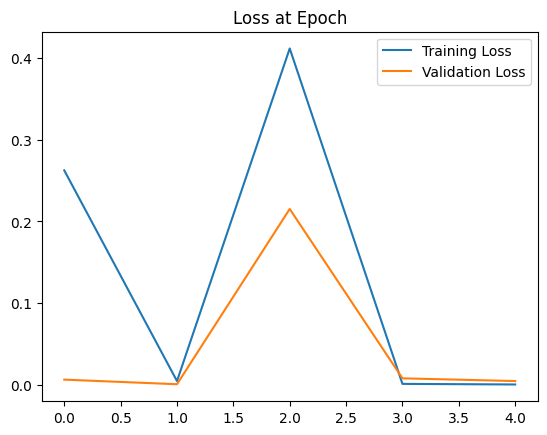

In [34]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

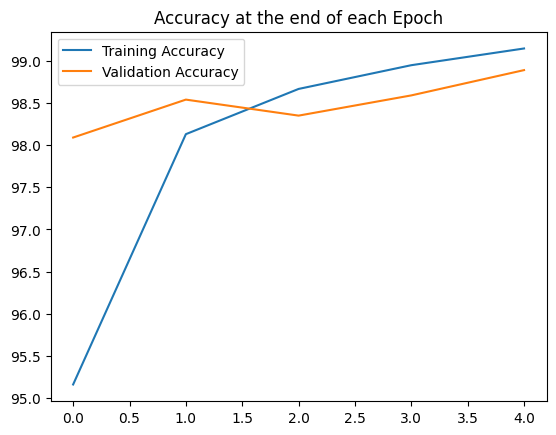

In [35]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [36]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [39]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()


In [44]:
correct.item()/len(test_data)*100

98.89

In [48]:
test_data[4346][0].shape

torch.Size([1, 28, 28])

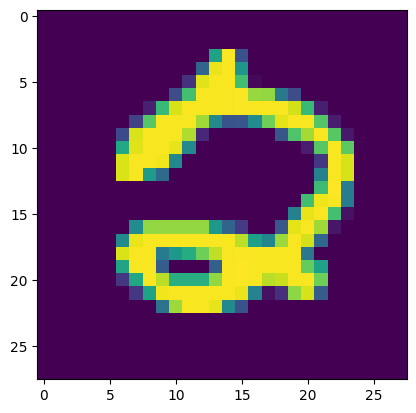

In [75]:
plt.imshow(test_data[1984][0].reshape(28, 28))

In [76]:
test_data[1984][1]

2

In [77]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1984][0].view(1, 1, 28, 28))

In [78]:
new_prediction.argmax()

tensor(2)